In [35]:
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
%matplotlib inline
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
sns.set_style('white')

In [2]:
data=pd.read_excel('Crime-FBI-2013-Washington state.xls')

In [3]:
data.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,WASHINGTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson
4,Aberdeen,16408,58,0,11,NaN,13,34,944,208,624,112,5


In [4]:
data.columns=data.loc[3,:].values
data.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,WASHINGTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson
4,Aberdeen,16408,58,0,11,NaN,13,34,944,208,624,112,5


In [5]:
# Cleaning up blank columns and changing the columns to short names
data=data.iloc[4:186, 0:13]
data.rename(columns={'Murder and\nnonnegligent\nmanslaughter': 'Murder'}, inplace=True)
data.rename(columns={'Property\ncrime': 'Property_crime'}, inplace=True)
data.rename(columns={'Rape\n(revised\ndefinition)1': 'Rape_1'}, inplace=True)
data.rename(columns={'Rape\n(legacy\ndefinition)2': 'Rape_2'}, inplace=True)
data.rename(columns={'Larceny-\ntheft': 'Larceny_theft'}, inplace=True)
data.reset_index(drop=True).head()

,City,Population,Violent crime,Murder,Rape_1,Rape_2,Robbery,Aggravated assault,Property_crime,Burglary,Larceny_theft,Motor vehicle theft,Arson
0,Aberdeen,16408,58,0,11,NaN,13,34,944,208,624,112,5
1,Airway Heights,6441,6,0,0,NaN,6,0,333,72,213,48,0
2,Algona,3123,0,0,0,NaN,0,0,73,22,42,9,0
3,Anacortes,15980,21,0,6,NaN,3,12,559,127,402,30,7
4,Arlington,18425,37,0,NaN,3,11,23,1124,198,791,135,0


In [6]:
# Data imputation using highly correlated another variable
#and delete remaining missing values.
data.Rape_1 = np.where(data.Rape_1.isnull(), data.Rape_2, data.Rape_1)
data.drop('Rape_2',axis=1, inplace=True)
data.dropna(how='all', axis=0, inplace=True)

#Adding new features
data['Murder_binary']=np.where(data['Murder'] > 0, 1,0)

# Finding the first quartile to add new binary outcome variable
data.Property_crime.quantile([0.25,0.5,0.75])
# categorizing the safe and unsafe of a property based on property_Crime
# property_crime below first quartile I considered safe and above first 
#quartile is unsafe
safe_level=data.Property_crime.quantile([0.50]).values[0]
data['Safety']=np.where(data['Property_crime'] < safe_level, 1,0)
data.head()

,City,Population,Violent crime,Murder,Rape_1,Robbery,Aggravated assault,Property_crime,Burglary,Larceny_theft,Motor vehicle theft,Arson,Murder_binary,Safety
4,Aberdeen,16408,58,0,11,13,34,944,208,624,112,5,0,0
5,Airway Heights,6441,6,0,0,6,0,333,72,213,48,0,0,0
6,Algona,3123,0,0,0,0,0,73,22,42,9,0,0,1
7,Anacortes,15980,21,0,6,3,12,559,127,402,30,7,0,0
8,Arlington,18425,37,0,3,11,23,1124,198,791,135,0,0,0


In [7]:
#Linear Regression model
LR = LogisticRegression(C=1e9)
X = data.loc[:, ~(data.columns).isin(['Safety','City'])]
Y = data['Safety']
# Fit the model.
fit = LR.fit(X, Y)
score=cross_val_score(LR,X=X,y=Y, cv=10)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [0.55       0.66666667 0.55555556 0.44444444 0.55555556 0.61111111
 0.66666667 1.         0.55555556 0.55555556]
Weighted Accuracy: 0.62 (+/- 0.28)


C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [8]:
# Added this new feature to know the effect on Logistic regression
data['Property_crime_per_100people']=(data['Property_crime']/data['Population'])*100

In [9]:
#Linear Regression model
LR = LogisticRegression(C=1e9)
X = data.loc[:, ~(data.columns).isin(['Safety','City'])]
Y = data['Safety']
# Fit the model.
fit = LR.fit(X, Y)
score=cross_val_score(LR,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [0.9   1.    1.    1.    1.    1.    1.    0.9   1.    0.9   1.    0.875
 1.    1.    0.875 1.    1.    0.875 1.    1.   ]
Weighted Accuracy: 0.97 (+/- 0.10)


C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Conclusion: There is a big increase in accuracy from 62% to 97% with addition of just one feature. Probably that one feature summarised or represented all the variance in X and helped in regression.

In [10]:
#Adding more features
data['Burglary'].where(data['Burglary'] !=0, np.nan, inplace=True)
data['Property_crime'].where(data['Property_crime'] !=0, np.nan, inplace=True)
data['Burglary_per_100_Property_crimes']= ((data['Burglary'])/(data['Property_crime']))*100
data.fillna(0, inplace=True)

#Adding theft feature
data['Theft']=data['Larceny_theft']+data['Motor\nvehicle\ntheft']

In [11]:
#Vanila Logistic Regression model on 15 features
LR = LogisticRegression(C=1e9)
X = data.loc[:, ~(data.columns).isin(['Safety','City'])]
Y = data['Safety']
# Fit the model.
fit = LR.fit(X, Y)
score=cross_val_score(LR,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [1.    1.    1.    1.    1.    1.    1.    0.9   1.    1.    0.9   1.
 1.    1.    1.    1.    1.    1.    1.    0.875]
Weighted Accuracy: 0.98 (+/- 0.08)


C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

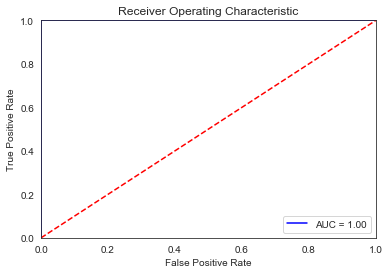

In [40]:
fpr, tpr, threshold = metrics.roc_curve(Y, LR.predict(X))
roc_auc = metrics.auc(fpr, tpr)

#plotting ROC/AUC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Since the Vanilla Logistic regression fit so well got a doubt if it is overfit.so checked the data with Train and test data to confirm if it is overfit or not. If it is not overfit it will perform almost that well with even test dataset

In [41]:
trainsize = int(data.shape[0] / 2)
data_test = data.iloc[trainsize:, :].copy()
data_train = data.iloc[:trainsize, :].copy()

In [42]:
#Vanila Logistic Regression model on 15 features
LR = LogisticRegression(C=1e9)
X = data_test.loc[:, ~(data.columns).isin(['Safety','City'])]
Y = data_test['Safety']

# Fit the model.
fit = LR.fit(X, Y)

X = data_train.loc[:, ~(data.columns).isin(['Safety','City'])]
Y = data_train['Safety']
score=cross_val_score(LR,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   0.75 1.   1.   1.  ]
 Accuracy: 0.99 (+/- 0.11)


C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nagad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

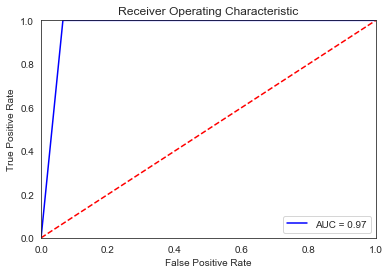

In [43]:
fpr, tpr, threshold = metrics.roc_curve(Y, LR.predict(X))
roc_auc = metrics.auc(fpr, tpr)

#plotting ROC/AUC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The above resutls proved beyond doubt that the model is not overfitting with accuracy and ROC/AUC all showing similar results if not even better with new unseen test data.

In [32]:
#Ridge Logistic Regression model on 15 features
RR = linear_model.Ridge(alpha=12, fit_intercept=False)
# Fit the model.
RR.fit(X, Y)
score=cross_val_score(RR,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [-2.88735136e-01 -6.96200933e-03  4.57814700e-01 -1.74162150e+00
  1.63854196e-01  1.82423519e-01 -6.83043750e-01  3.53229549e-01
  3.46614716e-01 -2.39909400e-01  4.65756114e-01  3.78984305e-01
  4.76899852e-01 -5.00430228e-01 -8.04235260e-01 -1.56416290e+00
 -5.02807263e+00  1.31622522e-01 -2.38924308e-01  1.21445169e-03]
Weighted Accuracy: -0.41 (+/- 2.45)


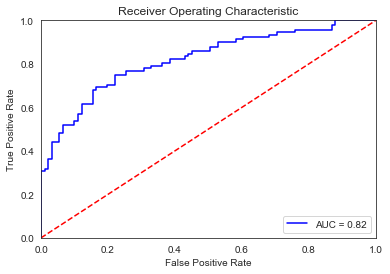

In [36]:
fpr, tpr, threshold = metrics.roc_curve(Y, RR.predict(X))
roc_auc = metrics.auc(fpr, tpr)

#plotting ROC/AUC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
#Ridge Logistic Regression model on 15 features
RC = linear_model.RidgeClassifier(alpha=12, fit_intercept=False)
# Fit the model.
RC.fit(X, Y)
score=cross_val_score(RC,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


The score or accuracy [0.7   0.8   0.8   0.8   0.8   0.9   0.8   0.8   0.9   1.    0.8   1.
 0.75  0.875 0.875 0.875 0.75  0.75  0.875 0.875]
Weighted Accuracy: 0.84 (+/- 0.15)


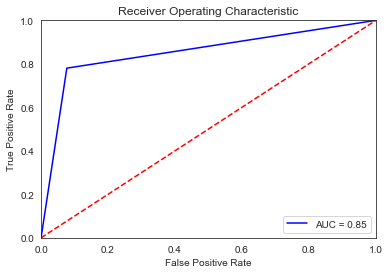

In [37]:
fpr, tpr, threshold = metrics.roc_curve(Y, RC.predict(X))
roc_auc = metrics.auc(fpr, tpr)

#plotting ROC/AUC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
#Lasso Logistic Regression model on 15 features
lass = linear_model.Lasso(alpha=12)
# Fit the model.
lass.fit(X, Y)
score=cross_val_score(lass,X=X,y=Y, cv=20)
print ('The score or accuracy', score)
print(" Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

The score or accuracy [-3.48298233e-01  1.90403769e-01 -1.75070241e-01 -1.10764880e+00
  1.13462603e-01 -3.45244025e-01 -2.41241384e-01  2.67788536e-01
  2.26154646e-01  2.14721798e-01 -7.79479618e-02  1.06388792e-01
  8.54987507e-02 -7.96527348e-03  2.43335160e-02 -2.20452247e+01
 -4.44823719e-01  7.72004925e-02  2.01261297e-01 -7.85379645e-02]
Weighted Accuracy: -1.17 (+/- 9.60)


First of all the Lasso regression is being done on Binary outcome variable i.e categorical variable. That is why the model would have performed so poorly.

Second of all even the Ridge regression was done with Binary outcome variable and the accury was very low. There fore, I changed the ridge to RidgeClassifier so that it performs better.

Based on accuracy scores Vanilla Logistic regression performed much better than rest of the two models with accuracy score of 98% compared to others. The feauture selection and adding features was helpful in improving the accuracy of Vanilla Logistic Regression.

Based on AUC by plotting ROC found that Vanilla Logistic Regression performed extremely well with AUC of 1, where as Ridge Regression and Ridge Classifer performed  low with 0.82/0.85 AUC.

The Lasso I did not attempt to do the ROC since the accuracy was utterly poor. It would have been better if I could use Lasso for Categorical variables too.

Lastly, it felt better to test the Vanilla Logistic regression for overfitting and it came out with flying colours of accuracy with minimal error as evidenced by an AUC of 0.97 or 1.
